In [723]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [724]:
filename='4'
speed=1
img = cv2.imread(filename+".jpg")
param=3

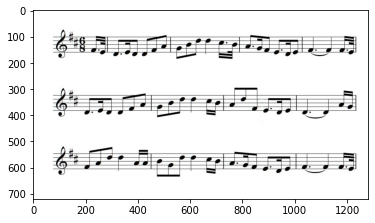

In [725]:
plt.imshow(img)

In [726]:
img.shape

(720, 1280, 3)

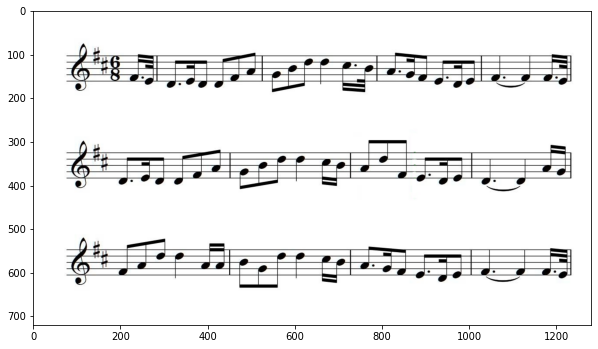

In [727]:
plt.figure(figsize=[10,10])
plt.imshow(img)

Gray scaled Img

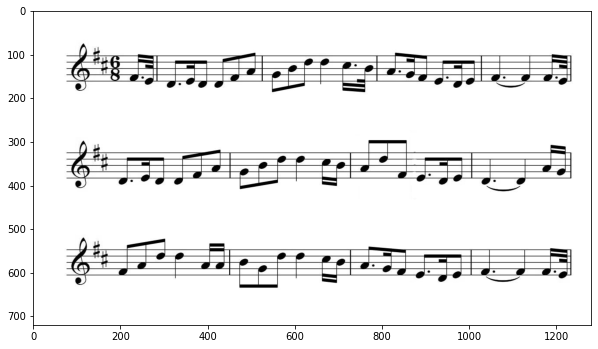

In [728]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=[10,10])
plt.imshow(img_gray,cmap="gray")

In [729]:
img_gray.shape

(720, 1280)

Used Otsu's thresholding

In [730]:
value,thr_img = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [731]:
value

140.0

In [732]:
thr_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

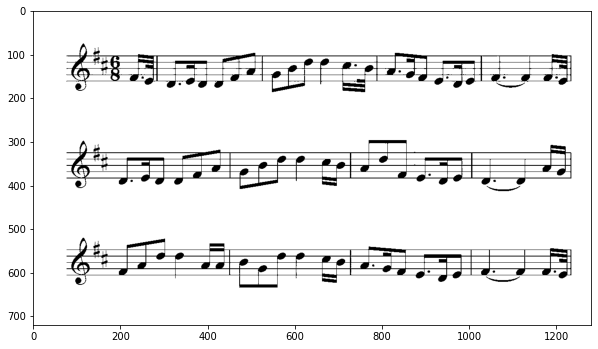

In [733]:
plt.figure(figsize=[10,10])
plt.imshow(thr_img,cmap="gray")

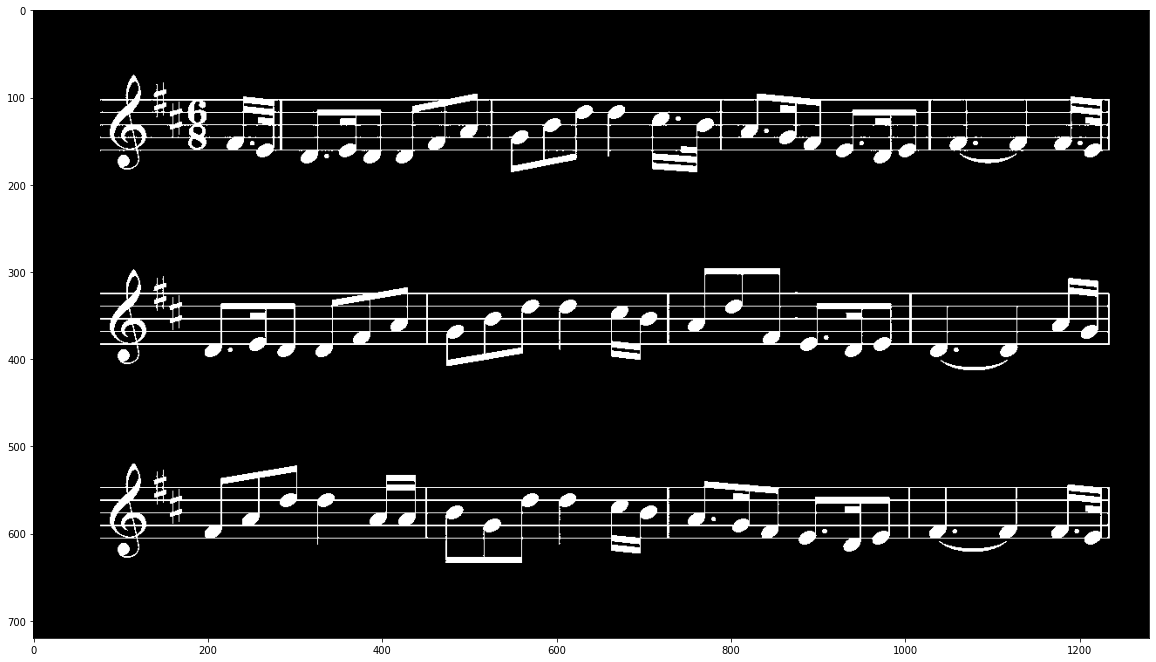

In [734]:
inv = 255-thr_img
plt.figure(figsize=[20,20])
plt.imshow(inv,cmap="gray")

In [735]:
np.unique(inv)

array([  0, 255], dtype=uint8)

In [736]:
kernel = np.ones((1,100),np.uint8)

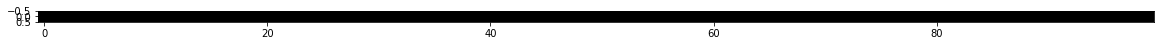

In [737]:
plt.figure(figsize=[20,20])
plt.imshow(kernel,cmap="gray")

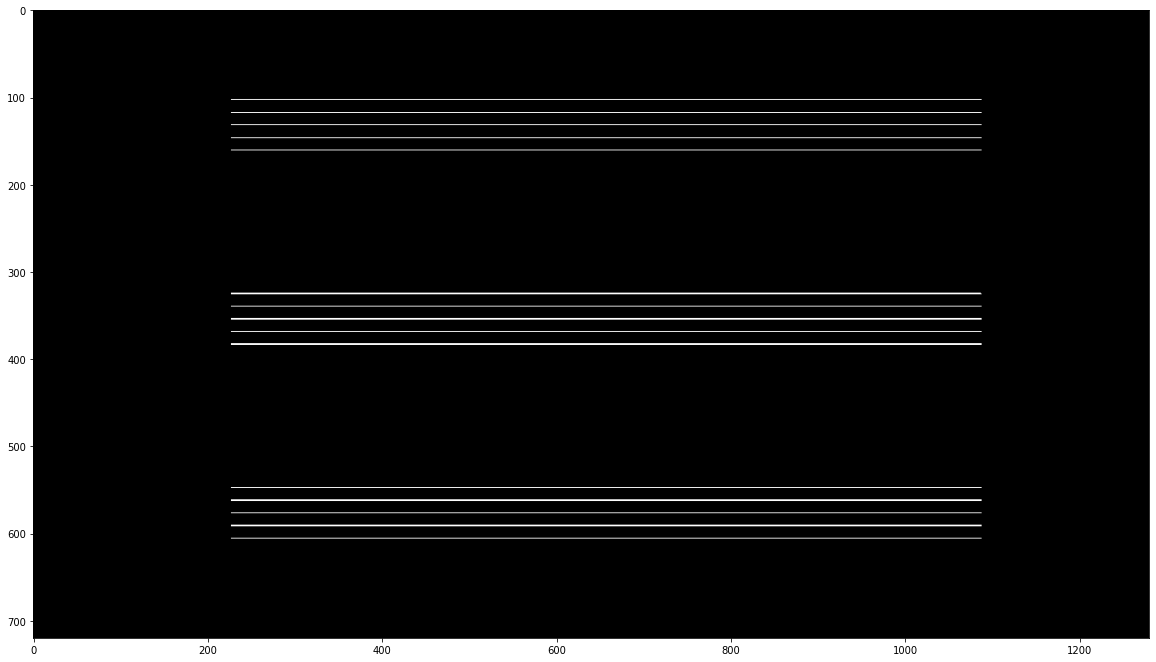

In [738]:
erosion = cv2.erode(inv,kernel,iterations = 1)
plt.figure(figsize=[20,20])
erosion = cv2.erode(erosion,kernel,iterations = 1)
erosion = cv2.erode(erosion,kernel,iterations = 1)


plt.imshow(erosion,cmap='gray')



In [739]:
reduced_width=cv2.reduce(erosion,1, cv2.REDUCE_AVG).reshape(-1)
h = img.shape[0]
w = img.shape[1]
result = np.zeros((h,w))

In [740]:
for row in range(h):
    if reduced_width[row]>0:
        cv2.line(result, (0,row), (w,row), (255), 1)

Horizontal Projection Image

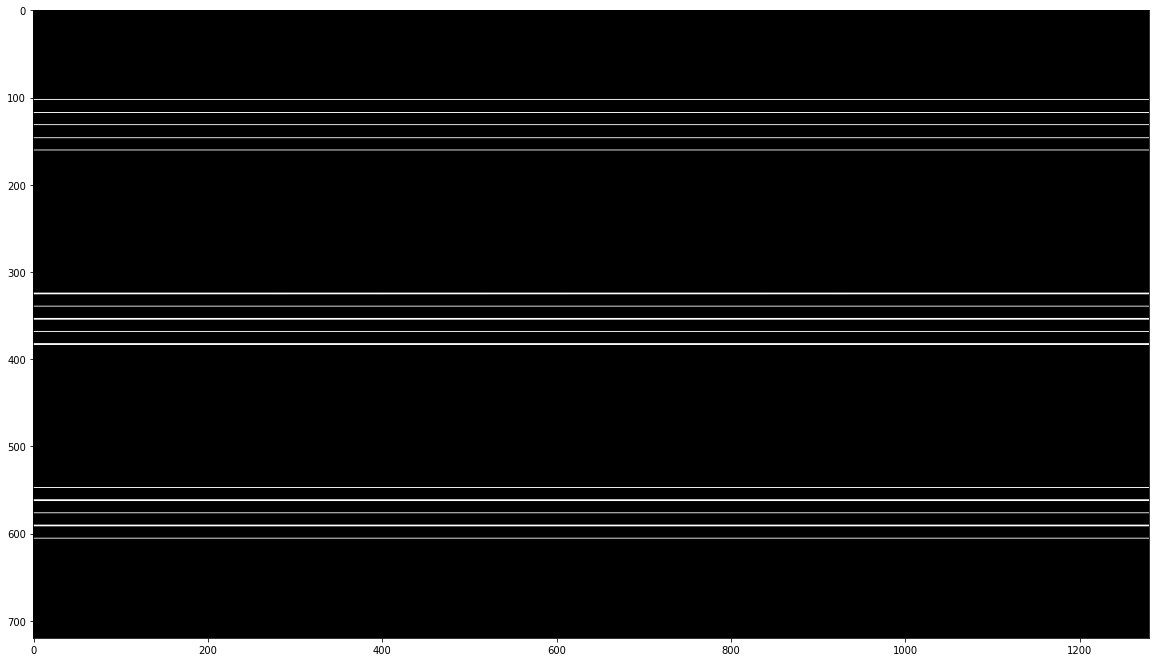

In [741]:
plt.figure(figsize=[20,20])
plt.imshow(result,cmap='gray')

In [742]:
notesonly = cv2.subtract(inv,result.astype(np.uint8))

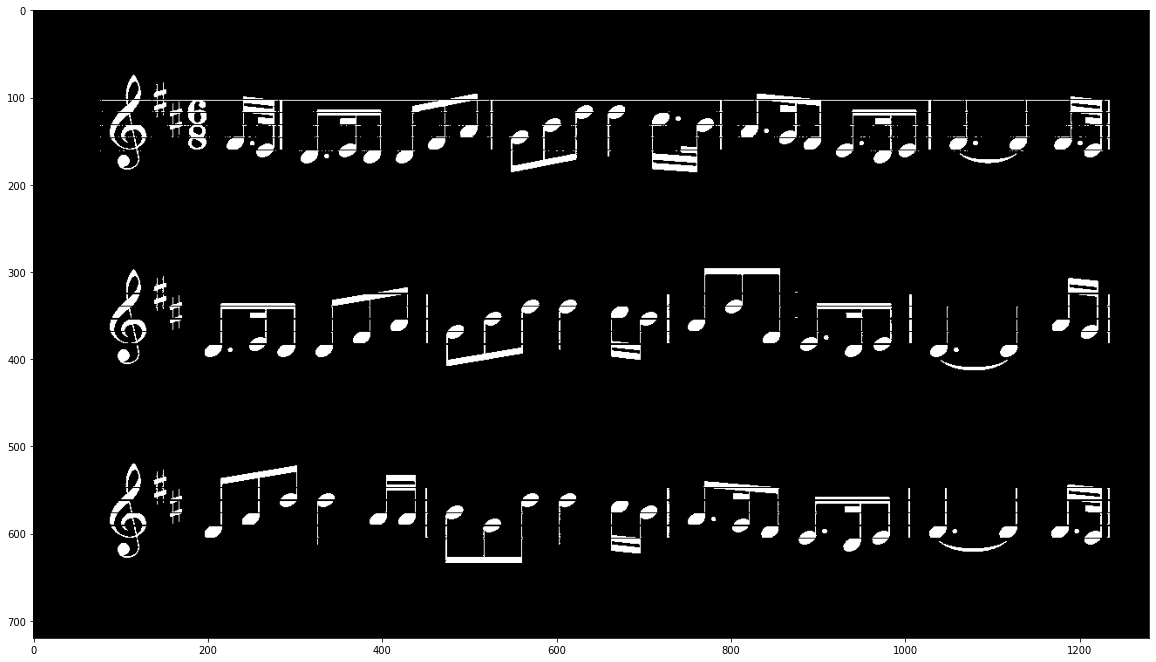

In [743]:
plt.figure(figsize=[20,20])
plt.imshow(notesonly,cmap='gray')

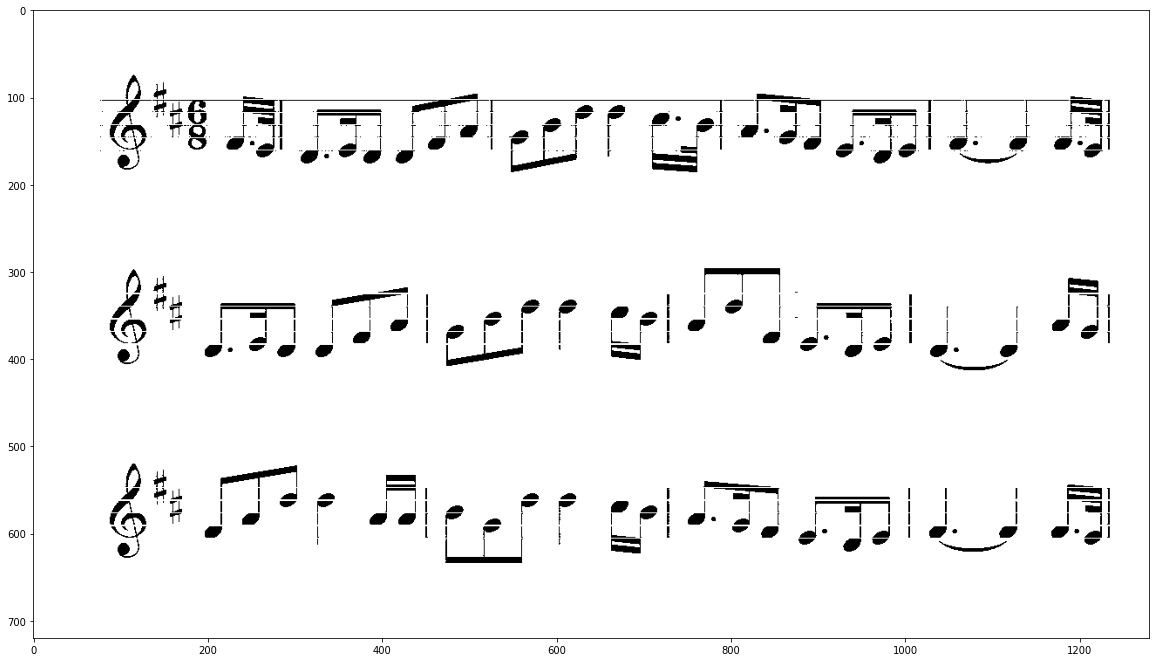

In [744]:
inv_notesonly = 255-notesonly
plt.figure(figsize=[20,20])
plt.imshow(inv_notesonly,cmap='gray')

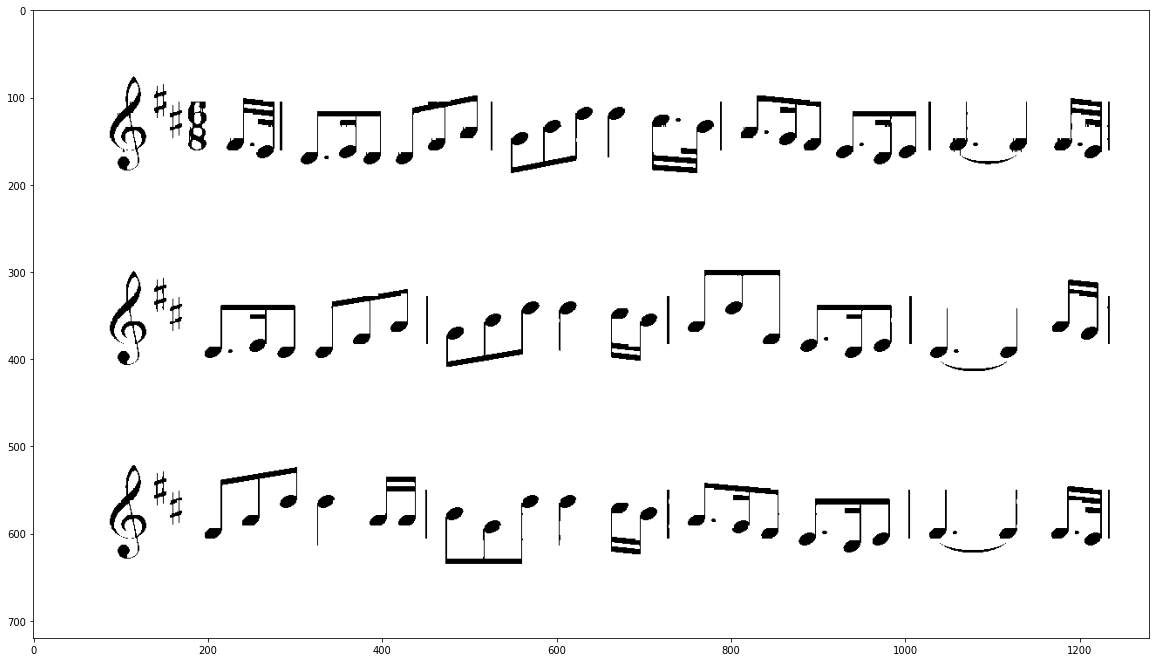

In [745]:
kernel3 = np.ones((param,1),np.uint8)
ero_inv_notes_only = cv2.erode(inv_notesonly,kernel3,iterations = 1)
ero_inv_notes_only = cv2.morphologyEx(ero_inv_notes_only, cv2.MORPH_CLOSE, np.ones((4,1)))
ero_inv_notes_only = cv2.dilate(ero_inv_notes_only, np.ones((4,1)), iterations = 1)

#ero_inv_notes_only = cv2.morphologyEx(ero_inv_notes_only, cv2.MORPH_CLOSE, np.ones((4,1)))

plt.figure(figsize=[20,20])
plt.imshow(ero_inv_notes_only,cmap='gray')

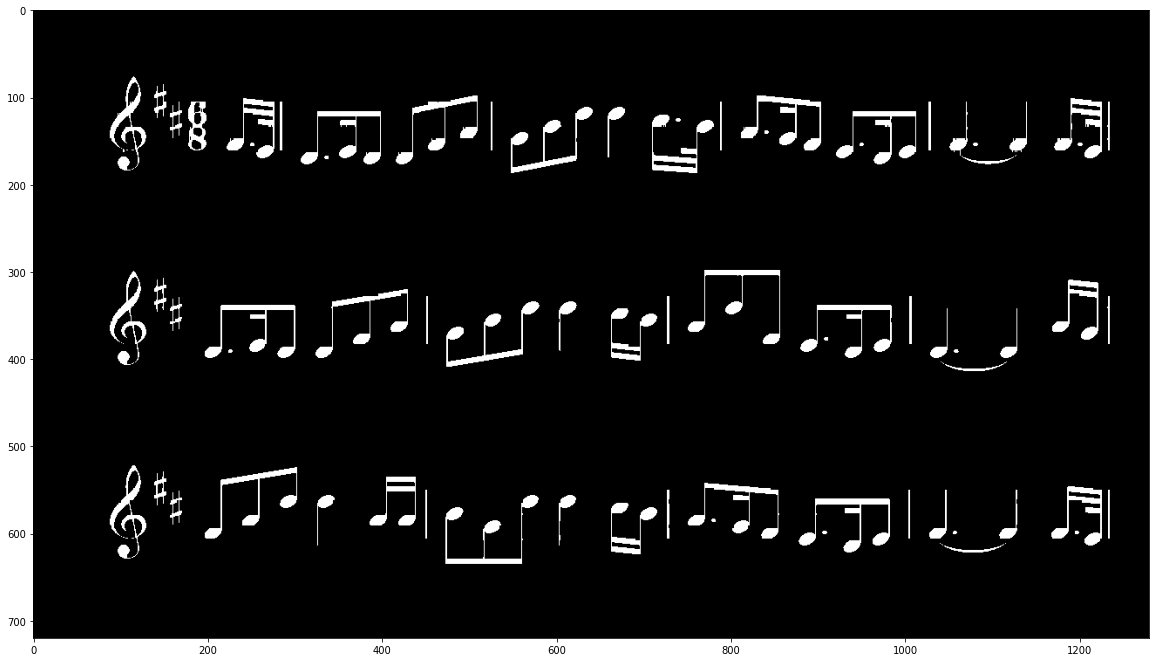

In [746]:
ero_notesonly = 255 - ero_inv_notes_only
plt.figure(figsize=[20,20])
plt.imshow(ero_notesonly,cmap='gray')

In [747]:
kernel2 = np.ones((40,1),np.uint8)

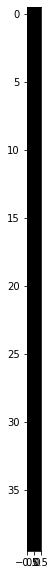

In [748]:
plt.figure(figsize=[10,10])
plt.imshow(kernel2,cmap='gray')

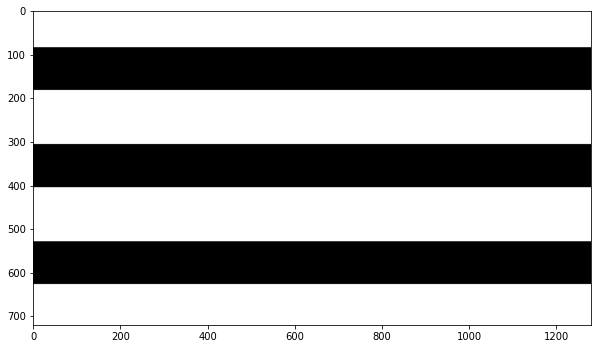

In [749]:
ver1 = cv2.erode(255-result,kernel2,iterations = 1)
plt.figure(figsize=[10,10])
plt.imshow(ver1,cmap='gray')

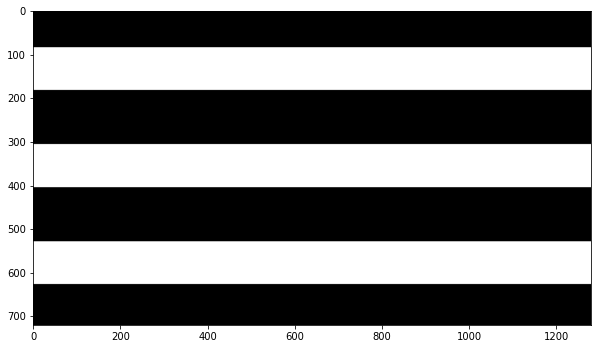

In [750]:
ver1 = 255-ver1
plt.figure(figsize=[10,10])
plt.imshow(ver1,cmap='gray')

83
181
305
404
528
626
718


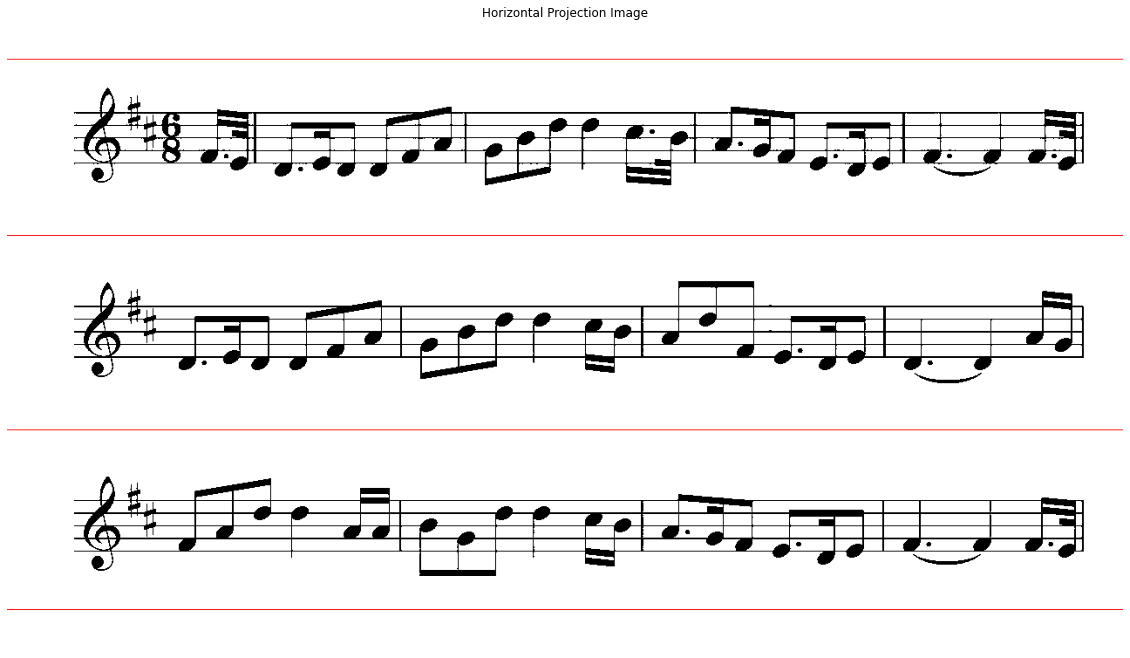

In [751]:
hist = cv2.reduce(ver1,1, cv2.REDUCE_AVG).reshape(-1)

lines=[]
flag=0
start=0
H,W = img.shape[:2]
for y in range(H-1):
    if hist[y]==255 or y==H-2:
        if flag==0:
            lines.append(start+int((y-start)/2))
            print(y)
            flag=1
    elif hist[y]==0 and flag==1:
        flag=0
        start=y
        print(start)
        
bi=thr_img
bi = cv2.cvtColor(bi, cv2.COLOR_GRAY2BGR)
for y in lines:
    cv2.line(bi, (0,y), (W, y), (255,0,0), 1)

plt.figure(figsize=[20,20])
plt.imshow(bi)
plt.axis('off')
plt.title('Horizontal Projection Image')
plt.show()

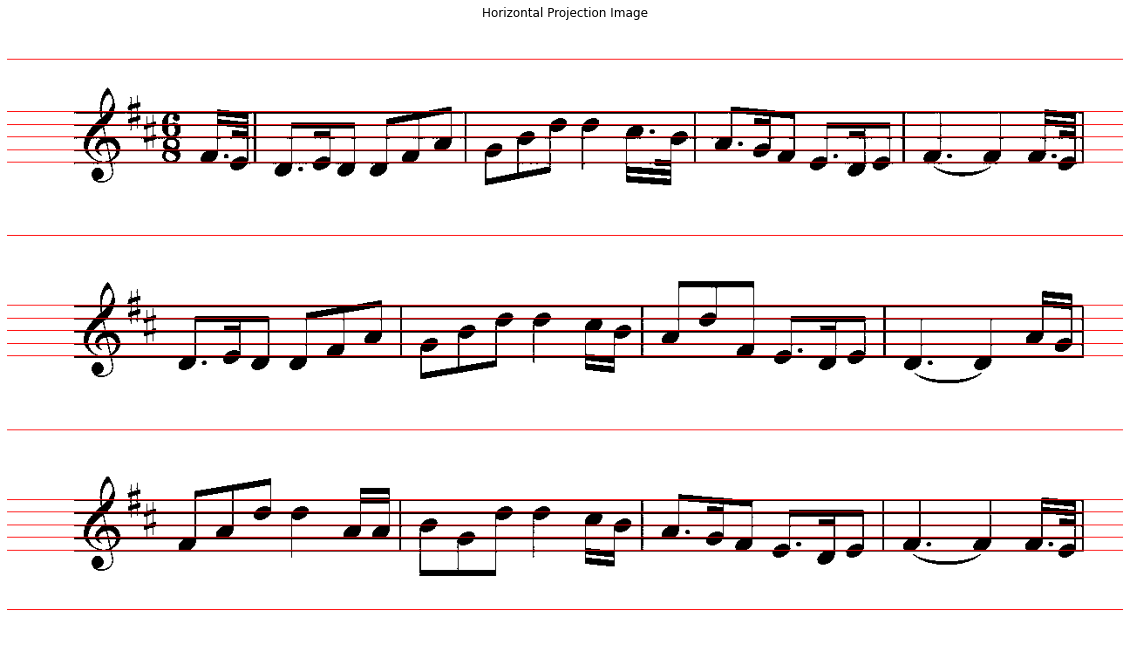

In [752]:
hist2 = cv2.reduce(result,1, cv2.REDUCE_AVG).reshape(-1)

staves=[]
flag=0
start=0
H,W = img.shape[:2]
for y in range(H-1):
    if hist2[y]<1 and hist2[y+1]>1:
        staves.append(y)
        

for y in staves:
    cv2.line(bi, (0,y), (W, y), (255,0,0), 1)

plt.figure(figsize=[20,20])
plt.imshow(bi)
plt.axis('off')
plt.title('Horizontal Projection Image')
plt.show()



In [753]:
from scipy import stats
def group(L):
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group


# Quarter Notes Detection

In [754]:
def circle_element(r):
    s=np.zeros((2*r+1,2*r+1))
    for i in range(2*r+1):
        for j in range(2*r+1):
            if(np.sqrt((i-r)**2+(j-r)**2)<=r):
                s[i,j]=1
    return np.uint8(s)

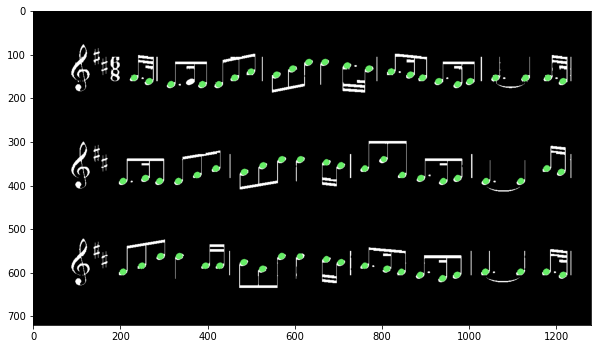

In [755]:
bw_notes = ero_notesonly.copy()
bw_notes3d = cv2.cvtColor(bw_notes, cv2.COLOR_GRAY2BGR)

green = [102,237,102]
for i in range(len(lines)-1):
    notes_row=inv[lines[i]:lines[i+1],:]
    bw_notes3d_row=bw_notes3d[lines[i]:lines[i+1],:]
    morphed_row=cv2.morphologyEx(notes_row, cv2.MORPH_OPEN, circle_element(int(0.47*(staves[1]-staves[0]))))
    bw_notes3d_row[morphed_row>0,0]=green[0]
    bw_notes3d_row[morphed_row>0,1]=green[1]
    bw_notes3d_row[morphed_row>0,2]=green[2]
    bw_notes3d[lines[i]:lines[i+1],:]=bw_notes3d_row.copy()
plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d)

# Cleft detection 

<Figure size 720x720 with 0 Axes>

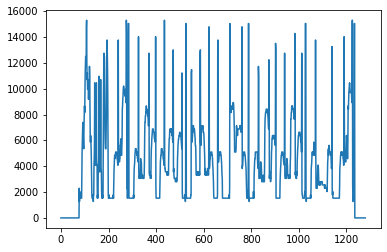

<Figure size 720x720 with 0 Axes>

In [756]:
i=0
notes_row=inv[lines[i]:lines[i+1],:]
plt.plot(np.sum(notes_row, axis=0))
plt.figure(figsize=[10,10])


From the left side, the first element that the staves are touching is the cleft

In [757]:
first_row_first_stave = staves[0]
second_row_first_stave = staves[int(len(staves)/3)*1]
third_row_first_stave = staves[int(len(staves)/3)*2]

In [758]:
first_row_first_stave, second_row_first_stave, third_row_first_stave

(101, 323, 546)

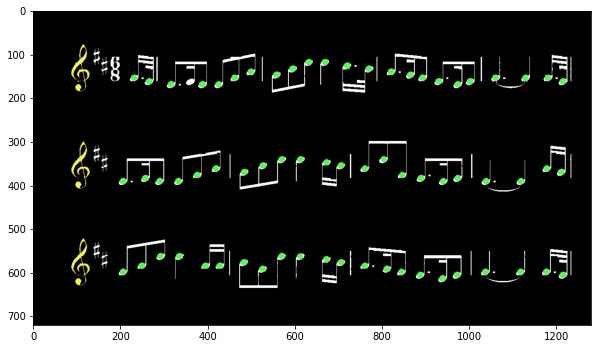

In [759]:
yellow = [242,237,106]
fir_col,sec_col,thir_col = -1,-1,-1
wid = bw_notes.shape[1]

for j in range(wid):
    if bw_notes[first_row_first_stave][j]==255:
        fir_col = j
        break
for j in range(wid):
    if bw_notes[second_row_first_stave][j]==255:
        sec_col = j
        break
for j in range(wid):
    if bw_notes[third_row_first_stave][j]==255:
        thir_col = j
        break
        
start_points = [[first_row_first_stave,fir_col],[second_row_first_stave,sec_col],[third_row_first_stave,thir_col]]

def dfs(point):
    row,col = point[0], point[1]
    dx = [-1,1,0,0]
    dy = [0,0,1,-1]
    
    for i in range(4):
        nrow = row+dx[i]
        ncol = col+dy[i]
        if bw_notes[nrow][ncol]==255:
            bw_notes[nrow][ncol] = 0
            bw_notes3d[nrow][ncol][0] = yellow[0]
            bw_notes3d[nrow][ncol][1] = yellow[1]
            bw_notes3d[nrow][ncol][2] = yellow[2]
            dfs([nrow,ncol])
    
    

for point in start_points:
    dfs(point)
    
i_array=255-inv
i_array=cv2.morphologyEx(i_array, cv2.MORPH_CLOSE, np.ones((1,2)))
i_array=255-i_array

cleft=np.zeros(len(lines)-1)
for j in range(len(lines)-1):
    notes_row=i_array[lines[j]:lines[j+1],:]
    sum1=np.sum(notes_row, axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    c=1
    for i in range(len(indcs_list)):
        a=indcs_list[i][0]
        b=indcs_list[i][1]
        section=ero_notesonly[lines[j]:lines[j+1],a:b]
        bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],a:b]
        if(np.sum(section)==0):
            continue
        else:
            if(np.sum(inv[staves[5*(j+1)-1]+5:lines[j+1],a:b])>0):
                cleft[j]=0
            else:
                cleft[j]=1
            bw_notes3d_row[section>0,0] = yellow[0]
            bw_notes3d_row[section>0,1] = yellow[1]
            bw_notes3d_row[section>0,2] = yellow[2]
            break

plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d,cmap='gray')

In [760]:
cleft

array([0., 0., 0.])

Clefts are yellow in color

# 1/8th Notes Detection

In [761]:
def vertical_element(r):
    s=np.zeros((r,r))
    s[:,int(r/2)]=1
    return np.uint8(s)
vertical_element(5)

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [762]:
def horizontal_element(r):
    s=np.zeros((r,r))
    s[int(r/2),:]=1
    return np.uint8(s)
horizontal_element(5)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [763]:
def diagonal_element(r,w):
    s=np.zeros((r,r))
    s[:r-w,int(r/2)]=1
    for i in range(w):
        s[i,int(r/2)+i]=1
        s[r-w+i,int(r/2)-i]=1
    return np.uint8(s)
diagonal_element(21,6)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [764]:
def diagonal_element_inverted(r,w):
    s=np.zeros((r-w,r-w))
    s[:,int(r/2)]=1
    for i in range(w):
        s[i,int(r/2)+i]=1
        s[-i-1,int(r/2)+i]=1
    return np.uint8(s)
diagonal_element_inverted(21,4)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

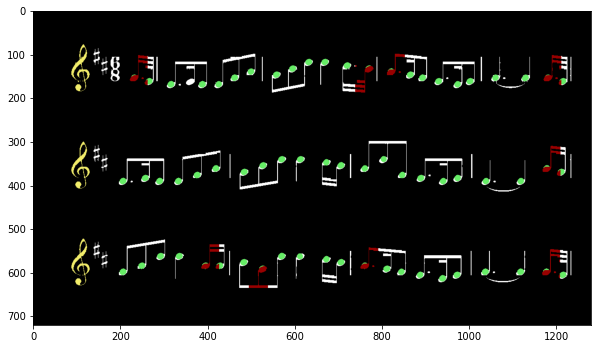

In [765]:
red = [153,0,0]
for i in range(len(lines)-1):
    notes_row=inv[lines[i]:lines[i+1],:]
    bw_notes3d_row=bw_notes3d[lines[i]:lines[i+1],:]
    morphed_row=cv2.morphologyEx(notes_row, cv2.MORPH_OPEN, diagonal_element(staves[3]-staves[0],8))
    indcs=np.where(morphed_row == 255)
    if(len(indcs[0])>0):
        indcs1=np.where(np.sum(morphed_row,axis=0)>0)
        indcs_list=list(group(indcs1[0]))
        for j in range(len(indcs_list)):
            a=indcs_list[j][0]-15
            b=indcs_list[j][1]+15
            morphed_row[:,a:b]=ero_notesonly[lines[i]:lines[i+1],a:b]
    #morphed_row=cv2.dilate(morphed_row,np.ones((3,3)),iterations=2)        
    bw_notes3d_row[morphed_row>0,0]=red[0]
    bw_notes3d_row[morphed_row>0,1]=red[1]
    bw_notes3d_row[morphed_row>0,2]=red[2]
    bw_notes3d[lines[i]:lines[i+1],:]=bw_notes3d_row.copy()
plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d)
    

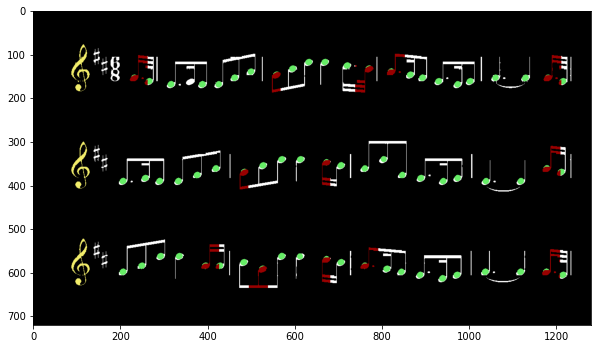

In [766]:
red = [153,0,0]
for i in range(len(lines)-1):
    notes_row=inv[lines[i]:lines[i+1],:]
    bw_notes3d_row=bw_notes3d[lines[i]:lines[i+1],:]
    morphed_row=cv2.morphologyEx(notes_row, cv2.MORPH_OPEN, diagonal_element_inverted(staves[3]-staves[0],5))
    indcs=np.where(morphed_row == 255)
    if(len(indcs[0])>0):
        indcs1=np.where(np.sum(morphed_row,axis=0)>0)
        indcs_list=list(group(indcs1[0]))
        for j in range(len(indcs_list)):
            a=indcs_list[j][0]
            b=indcs_list[j][1]+25
            morphed_row[:,a:b]=ero_notesonly[lines[i]:lines[i+1],a:b]
    #morphed_row=cv2.dilate(morphed_row,np.ones((3,3)),iterations=2)
    bw_notes3d_row[morphed_row>0,0]=red[0]
    bw_notes3d_row[morphed_row>0,1]=red[1]
    bw_notes3d_row[morphed_row>0,2]=red[2]
    bw_notes3d[lines[i]:lines[i+1],:]=bw_notes3d_row.copy()
plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d)

# KeyNote Signature Detection

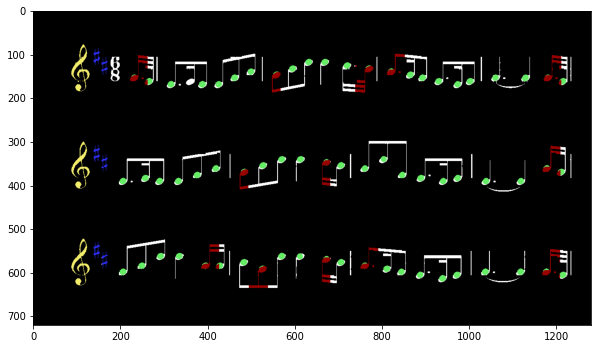

In [767]:
blue = [45,47,245]
no_hashes_list=[]
no_bs_list=[]
for j in range(len(lines)-1):
    notes_row=inv[lines[j]:lines[j+1],:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],:]
    sum1=np.sum(i_array[lines[j]:lines[j+1],:], axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    no_of_hashes=0
    no_of_bs=0
    for i in range(2,7):
        a=indcs_list[i][0]
        b=indcs_list[i][1]
        if(a==b):
            continue
        nr = notes_row[:,a:b]
        bw_n3d_r=bw_notes3d_row[:,a:b]
        morphed_row_circle=cv2.morphologyEx(nr, cv2.MORPH_OPEN, circle_element(5))
        if(np.sum(morphed_row_circle)>0):
            continue
        morphed_row=cv2.morphologyEx(nr, cv2.MORPH_OPEN, vertical_element(30))
        z=np.int16(np.sum(morphed_row,axis=0))
        z[z>0]=1
        diff_array=z[1:]-z[:-1]
        count=sum(diff_array>0)
        if(count>0 and count%2==0):
            no_of_hashes+=int(count/2)
            bw_n3d_r[bw_n3d_r[:,:,0]>0,0]=blue[0]
            bw_n3d_r[bw_n3d_r[:,:,1]>0,1]=blue[1]
            bw_n3d_r[bw_n3d_r[:,:,2]>0,2]=blue[2]
            bw_notes3d_row[:,a:b]=bw_n3d_r.copy()
    if(no_of_hashes==0):
        for i in range(2,7):
            a=indcs_list[i][0]
            b=indcs_list[i][1]
            if(a==b):
                continue
            bw_n3d_r=bw_notes3d_row[:,a:b]    
            z=ero_notesonly[lines[j]:lines[j+1],a:b]
            z1=cv2.morphologyEx(z, cv2.MORPH_CLOSE, circle_element(4))
            z=z1-z
            f=cv2.morphologyEx(z, cv2.MORPH_OPEN, circle_element(2))
            f1=np.sum(f,axis=1)
            f1=np.int16(f1)
            f1[f1>0]=1
            f1=f1[1:]-f1[:-1]
            if(np.sum(ero_notesonly[staves[5*j+3]+2:staves[5*j+4]-2,a:b])):
                continue
            if(np.sum(f>0)>0):
                print(i,j,np.sum(f1>0))
                no_of_bs+=np.sum(f1>0)
                if(no_of_bs>0):
                    bw_n3d_r[bw_n3d_r[:,:,0]>0,0]=blue[0]
                    bw_n3d_r[bw_n3d_r[:,:,1]>0,1]=blue[1]
                    bw_n3d_r[bw_n3d_r[:,:,2]>0,2]=blue[2]
                    bw_notes3d_row[:,a:b]=bw_n3d_r.copy()

    bw_notes3d[lines[j]:lines[j+1],:]= bw_notes3d_row.copy()       
    no_hashes_list.append(no_of_hashes)
    no_bs_list.append(no_of_bs)
plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d)

# 1/8th, 1/16th and 1/32th Notes Detection

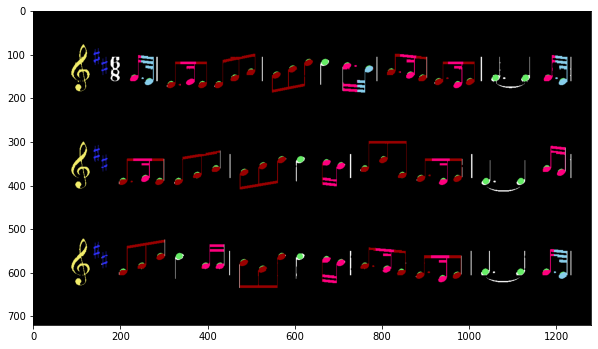

In [768]:
pink=[255,0,127]
aqua=[135,206,235]
for j in range(len(lines)-1):
    notes_row=inv[lines[j]:lines[j+1],:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],:]
    sum1=np.sum(notes_row, axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    for i in range(3,len(indcs_list)):
        a=indcs_list[i][0]
        b=indcs_list[i][1]
        element_size=45
        if(a==b or abs(a-b)<35):
            continue
        nr = ero_notesonly[lines[j]:lines[j+1],a:b]
        bw_n3d_r=bw_notes3d_row[:,a:b]

        morphed_row1=cv2.morphologyEx(nr, cv2.MORPH_OPEN, circle_element(int(0.35*(staves[1]-staves[0]))))
        z1=np.int16(np.sum(morphed_row1,axis=0))
        z1[0]=0
        z1[-1]=0
        z1[z1>0]=1
        diff_array1=z1[1:]-z1[:-1]

        element_size=18
        morphed_row=cv2.morphologyEx(nr-morphed_row1, cv2.MORPH_OPEN, horizontal_element(element_size))
        z=np.int16(np.sum(morphed_row,axis=1))
        z[0]=0
        z[-1]=0
        z[z>0]=1
        diff_array=z[1:]-z[:-1]
        z2=np.int16(np.sum(morphed_row,axis=0))
        if(sum(z2)<element_size):
            continue
        bw_n3d_r=bw_notes3d_row[:,a:b]
        if(np.sum(diff_array>0) and np.sum(diff_array1>0)):
            rois=np.where(z1==1)
            grps=list(group(rois[0]))
            for k in range(len(grps)):
                z_elem=np.int16(np.sum(morphed_row[:,grps[k][0]-1:grps[k][1]+5],axis=1))
                z_elem[0]=0
                z_elem[-1]=0
                z_elem[z_elem>0]=1
                z_elem_diff_array=z_elem[1:]-z_elem[:-1]
                beams=np.sum(z_elem_diff_array>0)
                final_thres=np.zeros(nr.shape)
                if(k==0):
                    final_thres[:,grps[k][0]:int((grps[k][1]+grps[k+1][0])/2)]=nr[:,grps[k][0]:int((grps[k][1]+grps[k+1][0])/2)]
                elif(k==(len(grps)-1)):
                    final_thres[:,int((grps[k][0]+grps[k-1][1])/2):grps[k][1]+5]=nr[:,int((grps[k][0]+grps[k-1][1])/2):grps[k][1]+5]
                else:
                    final_thres[:,int((grps[k][0]+grps[k-1][1])/2):int((grps[k][1]+grps[k+1][0])/2)]=nr[:,int((grps[k][0]+grps[k-1][1])/2):int((grps[k][1]+grps[k+1][0])/2)]
                #final_thres=cv2.dilate(final_thres,np.ones((3,3)),iterations=2)
                if(beams==1):
                    bw_n3d_r[final_thres>0,0]=red[0]
                    bw_n3d_r[final_thres>0,1]=red[1]
                    bw_n3d_r[final_thres>0,2]=red[2]
                    bw_notes3d_row[:,a:b]=bw_n3d_r.copy()
                elif(beams==2):
                    bw_n3d_r[final_thres>0,0]=pink[0]
                    bw_n3d_r[final_thres>0,1]=pink[1]
                    bw_n3d_r[final_thres>0,2]=pink[2]
                    bw_notes3d_row[:,a:b]=bw_n3d_r.copy()
                elif(beams==3):
                    bw_n3d_r[final_thres>0,0]=aqua[0]
                    bw_n3d_r[final_thres>0,1]=aqua[1]
                    bw_n3d_r[final_thres>0,2]=aqua[2]
                    bw_notes3d_row[:,a:b]=bw_n3d_r.copy()

            
plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d)      

Quarter notes are green in color, Quaver notes are red in color, Semiquaver notes are pink in color, Demisemiquaver notes are aqua in color

# Dots and Ties Detection

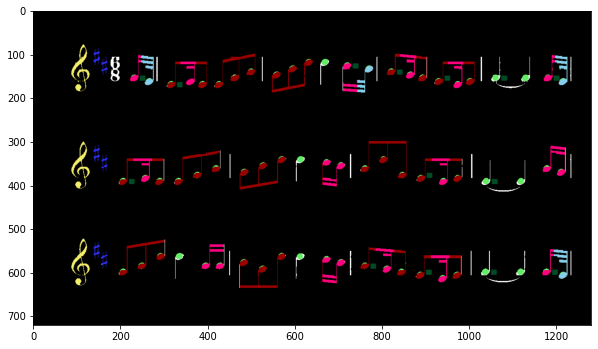

In [769]:
dark_green=[0,75,37]
for j in range(len(lines)-1):
    notes_row=inv[lines[j]:lines[j+1],:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],:]
    sum1=np.sum(notes_row, axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    if j==0:
        a=indcs_list[8][0]
    else:
        a=indcs_list[4][0]
    notes_row=ero_notesonly[lines[j]:lines[j+1],a:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],a:]
    output = cv2.connectedComponentsWithStats(notes_row, 4, cv2.CV_32S)
    (numLabels, labels, stats1, centroids) = output
    z=np.where((stats1[:, cv2.CC_STAT_AREA]<55)*(stats1[:, cv2.CC_STAT_AREA]>7))
    z=z[0]
    if len(z)>0:
        for i in range(len(z)):
            final=np.zeros(labels.shape)
            final[labels==z[i]]=255
            final=cv2.dilate(final,np.ones((5,5)),iterations=2) 
            bw_notes3d_row[final>0,0]=dark_green[0]
            bw_notes3d_row[final>0,1]=dark_green[1]
            bw_notes3d_row[final>0,2]=dark_green[2]
            bw_notes3d[lines[j]:lines[j+1],a:]=np.copy(bw_notes3d_row)
plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d)

In [770]:
def v_element(r,slope):
    s=np.zeros((r,r))
    s[int(r/2),int(r/2)]=1
    for i in range(1,int(r/2)+1):
        s[int(r/2)-int(slope*i),int(r/2)-i]=1
        s[int(r/2)-int(slope*i),int(r/2)+i]=1
    return np.uint8(s)
v_element(11,.5)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

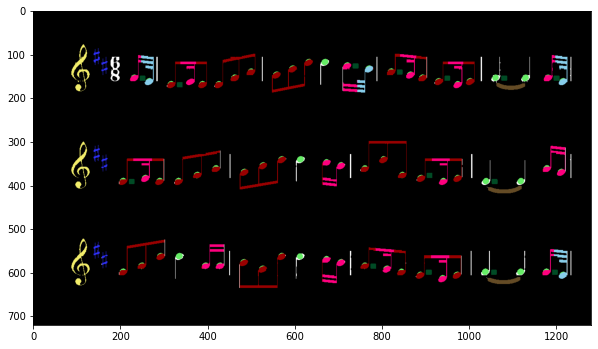

In [771]:
mustard=[100,75,37]
for j in range(len(lines)-1):
    notes_row=inv[lines[j]:lines[j+1],:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],:]
    sum1=np.sum(notes_row, axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    temp=cv2.morphologyEx(ero_notesonly, cv2.MORPH_OPEN,np.ones((1,4)))
    notes_row=temp[lines[j]:lines[j+1],:]
    notes_row1=ero_notesonly[lines[j]:lines[j+1],:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],:]
    for i in range(5,len(indcs_list)):
        a=indcs_list[i][0]
        b=indcs_list[i][1]
        nr = notes_row[:,a:b]
        bw_n3d_r=bw_notes3d_row[:,a:b]

        if(a==b or abs(a-b)<10):
            continue

        morphed_row=cv2.morphologyEx(nr, cv2.MORPH_OPEN, circle_element(5))
        morphed_row1=morphed_row-nr
        morphed_row1=cv2.morphologyEx(morphed_row1, cv2.MORPH_OPEN, v_element(31,0.1))
        if(np.sum(morphed_row1)==0):
            continue
        nr = notes_row1[:,a:b]
        output1 = cv2.connectedComponentsWithStats(nr, 4, cv2.CV_32S)
        (numLabels1, labels1, stats1, centroids1) = output1
        for k in range(numLabels1):
            if (stats1[k, cv2.CC_STAT_AREA]<30) or (stats1[k, cv2.CC_STAT_AREA]>1000):
                continue
            z=labels1==k
            z1=np.sum(np.sum(z,axis=0)>0)
            z2=np.sum(np.sum(z,axis=1)>0)
            
            if(z1>30 and z2<20):
                final=np.zeros(labels1.shape)
                final[labels1==k]=255
                final=cv2.dilate(final,np.ones((4,4)),iterations=2)
                bw_n3d_r[final>0,0]=mustard[0]
                bw_n3d_r[final>0,1]=mustard[1]
                bw_n3d_r[final>0,2]=mustard[2]
                bw_notes3d[lines[j]:lines[j+1],a:b]=np.copy(bw_n3d_r)

plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d)

# Half and Full Note Detection

In [772]:

def halfnote(crop_img):
    im=crop_img
    im2=cv2.morphologyEx(im, cv2.MORPH_CLOSE, circle_element(5))
    im2=im2-im
    im2=cv2.morphologyEx(im2, cv2.MORPH_OPEN, circle_element(3))
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
    im2=cv2.morphologyEx(im2, cv2.MORPH_DILATE, circle_element(5))
    return im2
def wholenote(crop_img):
    im=crop_img
    im2=cv2.morphologyEx(im, cv2.MORPH_CLOSE, circle_element(7))
    im2_1=cv2.morphologyEx(im, cv2.MORPH_CLOSE, circle_element(6))
    im2=im2-im2_1
    im2=cv2.morphologyEx(im2, cv2.MORPH_OPEN, circle_element(3))
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
    im2=cv2.morphologyEx(im2, cv2.MORPH_DILATE, circle_element(5))
    return im2

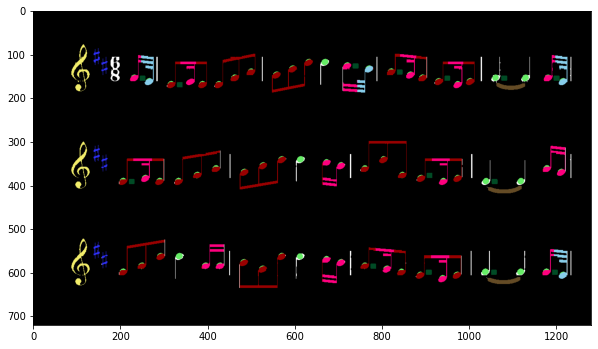

In [773]:
orange=[255,128,0]
violet=[204,153,255]
for j in range(len(lines)-1):
    notes_row=inv[lines[j]:lines[j+1],:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],:]
    sum1=np.sum(notes_row, axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    for i in range(5,len(indcs_list)):
        if(j==0 and i<10):
            continue
        a=indcs_list[i][0]
        b=indcs_list[i][1]
        nr = ero_notesonly[lines[j]:lines[j+1],a:b]
        bw_n3d_r=bw_notes3d_row[:,a:b]

        if(a==b or abs(a-b)<10):
            continue

        morphed_row1=cv2.morphologyEx(nr, cv2.MORPH_OPEN, circle_element(int(0.3*(staves[1]-staves[0]))))
        if(np.sum(morphed_row1)>0):
            continue
        final_thres=halfnote(nr)
        final_thres1=wholenote(nr)
        final_thres=cv2.dilate(final_thres,np.ones((3,3)),iterations=2)
        final_thres1=cv2.dilate(final_thres1,np.ones((3,3)),iterations=2) 
        bw_n3d_r[final_thres>0,0]=orange[0]
        bw_n3d_r[final_thres>0,1]=orange[1]
        bw_n3d_r[final_thres>0,2]=orange[2]
        bw_n3d_r[final_thres1>0,0]=violet[0]
        bw_n3d_r[final_thres1>0,1]=violet[1]
        bw_n3d_r[final_thres1>0,2]=violet[2]
        bw_notes3d_row[:,a:b]=bw_n3d_r.copy()
    
plt.figure(figsize=[10,10])
plt.imshow(bw_notes3d)      

# Rest Detection

In [774]:
final_staves=[]
for i in range(len(staves)):
    final_staves.append(staves[i])
    if(i%5!=4):
        final_staves.append((staves[i]+staves[i+1])/2)

In [775]:
line_no=0
stave_list=np.array(final_staves[line_no*9:line_no*9+9])
a=np.diff(stave_list)
a1=np.insert(a,0,[a[-1],a[-2]])
a2=np.append(a,[a[0],a[1]])
a1=np.cumsum(a1)
a2=np.cumsum(a2)
a1_f=stave_list[0]-np.flip(a1)
a2_f=stave_list[-1]+a2
final_stave_list=np.hstack((a1_f,stave_list,a2_f))

In [776]:
stave_list=np.array(final_staves[0*9:0*9+9])
final_staves[0]-np.diff(stave_list)

array([93.5, 93.5, 94. , 94. , 93.5, 93.5, 94. , 94. ])

<Figure size 1440x1440 with 0 Axes>

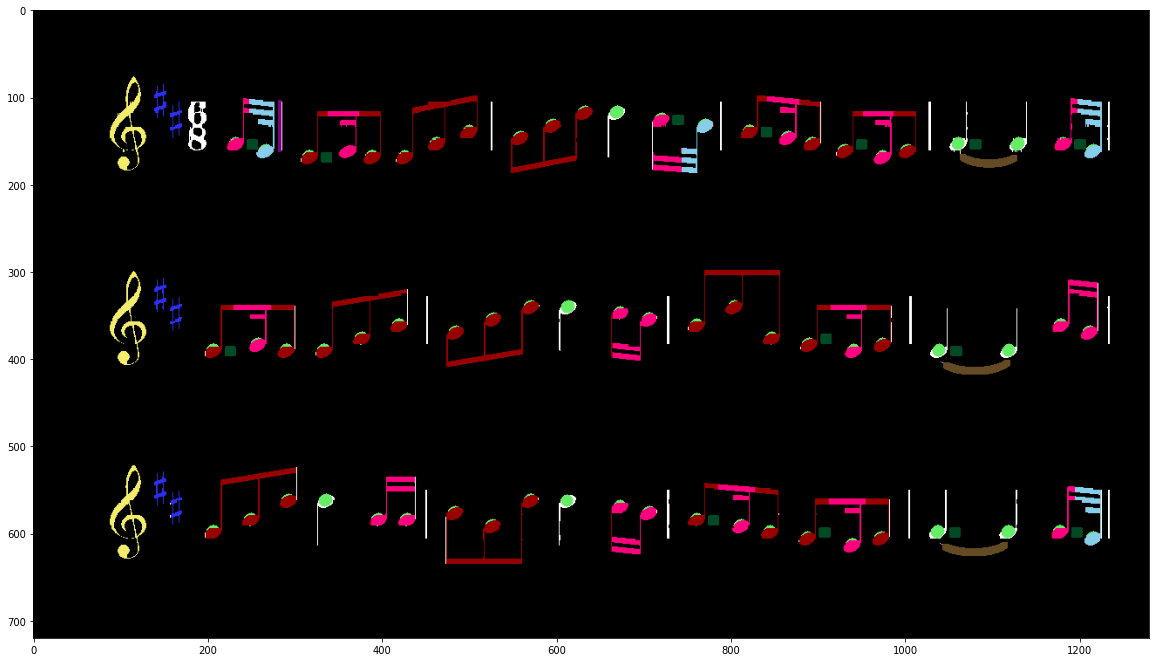

In [777]:
purple=[127,0,127]
plt.figure(figsize=[20,20])
z=cv2.dilate(ero_notesonly, np.ones((10,10)), iterations = 1)
z=cv2.morphologyEx(z, cv2.MORPH_OPEN, np.ones((15,15)))
for j in range(len(lines)-1):
    notes_row=inv[lines[j]:lines[j+1],:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],:]
    sum1=np.sum(notes_row, axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    notes_row=z[lines[j]:lines[j+1],:]
    for i in range(6,len(indcs_list)):
        a=indcs_list[i][0]
        b=indcs_list[i][1]
        if(a==b or abs(a-b)<3 or abs(a-b)>(stave_list[4]-stave_list[1])):
            continue
        nr = notes_row[:,a:b]
        bw_n3d_r=bw_notes3d_row[:,a:b]
        sum_rows=np.sum(nr,axis=1)
        sum_rows1=np.where(sum_rows>0)
        if(len(sum_rows1[0])>0):
            elem_list=list(group(sum_rows1[0]))
            x=np.array(elem_list)
            dists=x[:,1]-x[:,0]
            if(max(dists)<(stave_list[4]-stave_list[0])):
                continue
            final_thres = ero_notesonly[lines[j]:lines[j+1],a:b]
            final_thres=cv2.dilate(final_thres,np.ones((3,3)),iterations=2)
            bw_n3d_r[final_thres>0,0]=purple[0]
            bw_n3d_r[final_thres>0,1]=purple[1]
            bw_n3d_r[final_thres>0,2]=purple[2]
            bw_notes3d_row[:,a:b]=bw_n3d_r.copy()
plt.figure(figsize=[20,20])
plt.imshow(bw_notes3d)

11 2 56 26.1 2


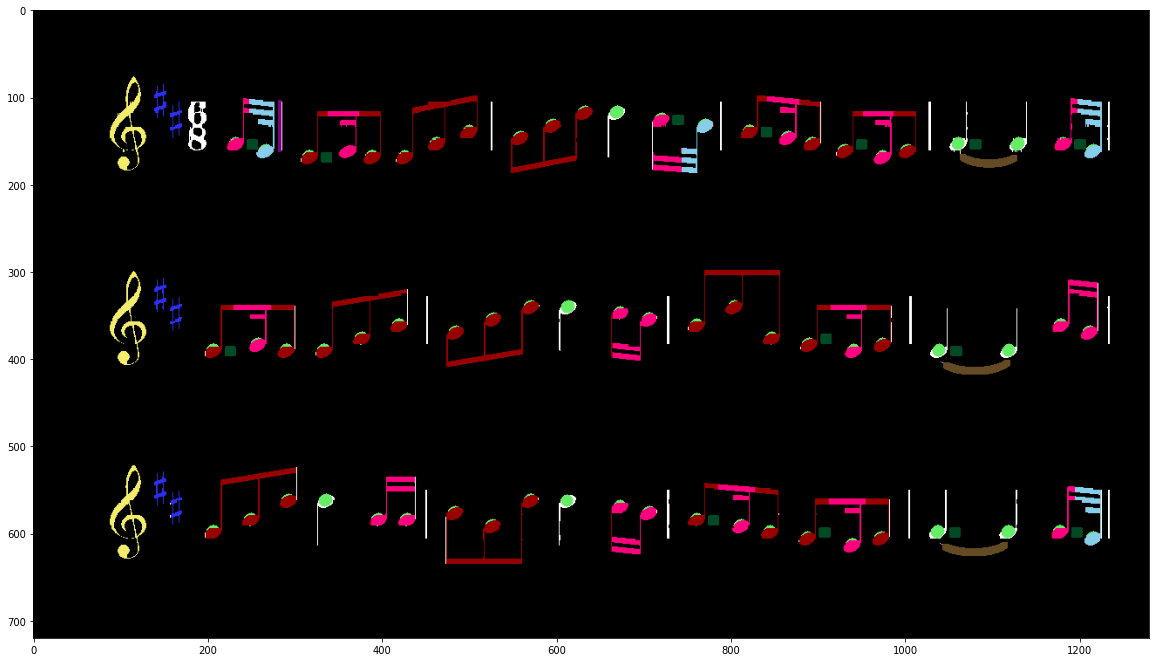

In [778]:
purple1=[127,1,127]
purple2=[127,2,127]
eroded1=cv2.morphologyEx(ero_notesonly, cv2.MORPH_OPEN, horizontal_element(3))
dilated1=cv2.dilate(ero_notesonly, np.ones((1,8)), iterations = 1)
for j in range(len(lines)-1):
    notes_row=inv[lines[j]:lines[j+1],:]
    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],:]
    sum1=np.sum(notes_row, axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    for i in range(len(indcs_list)):
        a=indcs_list[i][0]
        b=indcs_list[i][1]
        if j==0 and i<8:
            continue
        elif j>0 and i<4:
            continue
        if abs(a-b)>(stave_list[4]-stave_list[1]):
            continue
        notes_row=eroded1[lines[j]:lines[j+1],a:b]
        bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],a:b]
        output = cv2.connectedComponentsWithStats(notes_row, 4, cv2.CV_32S)
        (numLabels, labels, stats1, centroids) = output
        z=np.where((stats1[:, cv2.CC_STAT_AREA]<55)*(stats1[:, cv2.CC_STAT_AREA]>7))
        z=z[0]
        if len(z)>0:
            notes_row=dilated1[lines[j]:lines[j+1],a:b]
            output = cv2.connectedComponentsWithStats(notes_row, 4, cv2.CV_32S)
            (numLabels, labels, stats1, centroids) = output
            row_sum=np.sum(notes_row,axis=1)
            row_sum=np.sum(row_sum>0)
            print(i,j,row_sum,0.9*(staves[2]-staves[0]), numLabels)    
            notes_row=cv2.dilate(notes_row,np.ones((2,2)),iterations=5) 
            if(numLabels==2 and row_sum>0.75*(staves[2]-staves[0]) and row_sum<1.25*(staves[2]-staves[0])):
                if(len(z)==1):
                    notes_row=dilated1[lines[j]:lines[j+1],a-10:b+10]
                    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],a-10:b+10]
                    bw_notes3d_row=np.zeros(bw_notes3d_row.shape)
                    bw_notes3d_row[notes_row>0,0]=purple1[0]
                    bw_notes3d_row[notes_row>0,1]=purple1[1]
                    bw_notes3d_row[notes_row>0,2]=purple1[2]
                    bw_notes3d[lines[j]:lines[j+1],a-10:b+10]=np.copy(bw_notes3d_row)
                if(len(z)==2):
                    notes_row=dilated1[lines[j]:lines[j+1],a-10:b+10]
                    bw_notes3d_row=bw_notes3d[lines[j]:lines[j+1],a-10:b+10]
                    bw_notes3d_row=np.zeros(bw_notes3d_row.shape)
                    bw_notes3d_row[notes_row>0,0]=purple2[0]
                    bw_notes3d_row[notes_row>0,1]=purple2[1]
                    bw_notes3d_row[notes_row>0,2]=purple2[2]
                    bw_notes3d[lines[j]:lines[j+1],a-10:b+10]=np.copy(bw_notes3d_row)
                    
plt.figure(figsize=[20,20])
plt.imshow(bw_notes3d,cmap='gray')

# Audio Synthesis

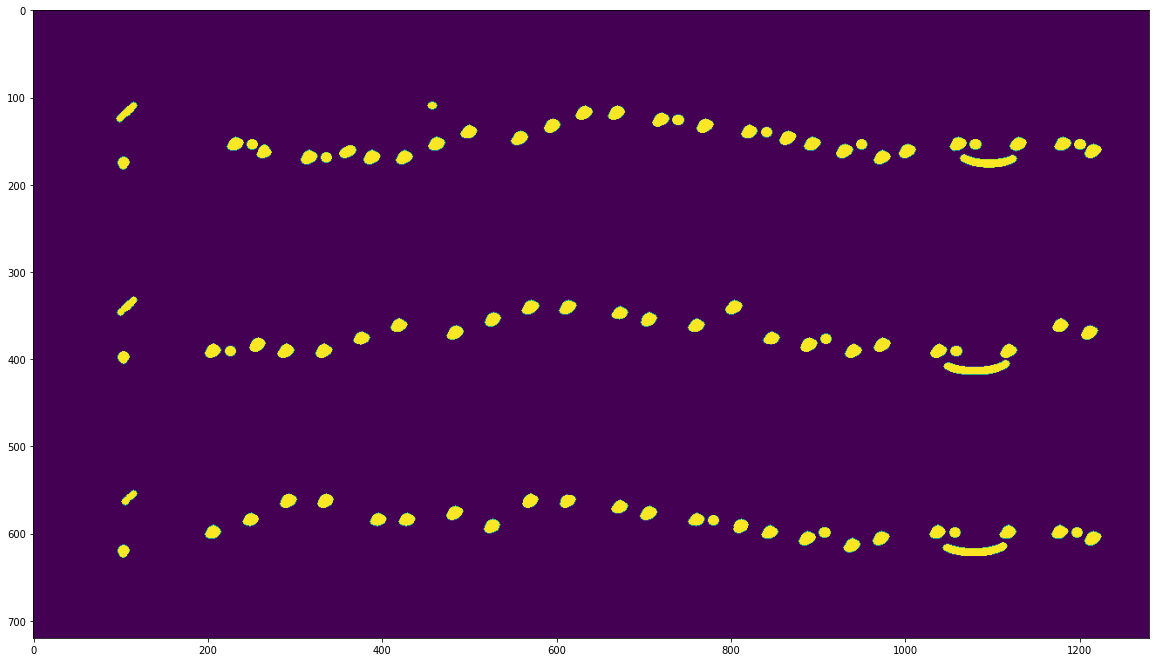

In [779]:
temp1=cv2.cvtColor(bw_notes3d, cv2.COLOR_RGB2GRAY)
temp1[temp1>0]=255
temp2=cv2.morphologyEx(temp1, cv2.MORPH_OPEN, diagonal_element(staves[3]-staves[0],8))
temp1=temp1-temp2
temp2=cv2.morphologyEx(temp1, cv2.MORPH_OPEN, diagonal_element_inverted(staves[3]-staves[0],5))
temp1=temp1-temp2
temp2=cv2.morphologyEx(temp1, cv2.MORPH_OPEN, np.ones((80,1)))
temp1=temp1-temp2
temp1=cv2.morphologyEx(temp1, cv2.MORPH_OPEN, circle_element(4))
plt.figure(figsize=[20,20])
plt.imshow(temp1)

In [780]:
def Note(centroid_y, line_no):
    stave_list=np.array(final_staves[line_no*9:line_no*9+9])
    a=np.diff(stave_list)
    a1=np.insert(a,0,[a[-1],a[-2]])
    a2=np.append(a,[a[0],a[1]])
    a1=np.cumsum(a1)
    a2=np.cumsum(a2)
    a1_f=stave_list[0]-np.flip(a1)
    a2_f=stave_list[-1]+a2
    final_stave_list=np.hstack((a1_f,stave_list,a2_f))
    dist=np.array(abs(centroid_y-final_stave_list))
    line=np.argmin(dist)
    vals=['b','a','g','f','e','d','c','b','a','g','f','e','d','c','b','a','g','f','e','d','c','b','a','g','f','e','d','c','b',]
    value=vals[line]
    if(no_of_hashes>0):
        if(no_of_hashes>=1):
            if(value=='f'):
                value='f#'
        if(no_of_hashes>=2):
            if(value=='c'):
                value='c#'
        if(no_of_hashes>=3):
            if(value=='g'):
                value='g#'
        if(no_of_hashes>=4):
            if(value=='d'):
                value='d#'
        if(no_of_hashes>=5):
            if(value=='a'):
                value='a#'
        if(no_of_hashes>=6):
            if(value=='e'):
                value='e#'
        if(no_of_hashes>=7):
            if(value=='b'):
                value='b#'
    else:
        if(no_of_bs>=1):
            if(value=='b'):
                value='bb'
        if(no_of_bs>=2):
            if(value=='e'):
                value='eb'
        if(no_of_bs>=3):
            if(value=='a'):
                value='ab'
        if(no_of_bs>=4):
            if(value=='d'):
                value='db'
        if(no_of_bs>=5):
            if(value=='g'):
                value='gb'
        if(no_of_hashes>=6):
            if(value=='c'):
                value='cb'
        if(no_of_bs>=7):
            if(value=='f'):
                value='fb'
    return value

In [781]:
def Octave(centroid_x, centroid_y):
    val=bw_notes3d[centroid_x,centroid_y]
    if(np.all(val==green)):
        return 4
    if(np.all(val==red)):
        return 8
    if(np.all(val==orange)):
        return 2
    if(np.all(val==violet)):
        return 1
    if(np.all(val==aqua)):
        return 32
    if(np.all(val==pink)):
        return 16
    if(np.all(val==dark_green)):
        return -1
    if(np.all(val==purple)):
        return 0
    if(np.all(val==purple1)):
        return -100
    if(np.all(val==purple2)):
        return -200
    if(np.all(val==mustard)):
        return -10
    return 100

In [782]:
note_list=[]
octave_list=[]
for j in range(len(lines)-1):
    notes_row=inv[lines[j]:lines[j+1],:]
    sum1=np.sum(notes_row, axis=0)
    mode_val=stats.mode(sum1[sum1!=0])[0][0]
    indcs=np.where(sum1!=mode_val)
    indcs_list=list(group(indcs[0]))
    notes_row=temp1[lines[j]:lines[j+1],:]
    for i in range(len(indcs_list)):
        a=indcs_list[i][0]
        b=indcs_list[i][1]
        nr = notes_row[:,a:b]
        output = cv2.connectedComponentsWithStats(nr, 4, cv2.CV_32S)
        (numLabels, labels, stats1, centroids) = output
        if(a==b):
            continue
        sorted_indices=np.argsort(centroids[:,0])
        flag=1

        for k in range(numLabels):

            if(stats1[sorted_indices[k], cv2.CC_STAT_AREA]==max(stats1[:, cv2.CC_STAT_AREA])):
                continue
            x_mean=int(lines[j]+centroids[sorted_indices[k],1])
            y_mean=int(a+centroids[sorted_indices[k],0])
            #print(i,j,x_mean,y_mean)
            note=Note(x_mean,j)
            octave=Octave(x_mean, y_mean)
            if(octave==100):
                continue
            if(octave==-1):
                octave_list[-1]=-octave_list[-1]
                continue
            if(octave==0):
                note='r'
                octave=4
            if(octave==-100):
                note='r'
                octave=8
            if(octave==-200):
                note='r'
                octave=16
            if(octave_list and octave_list[-1]==-10):
                if(octave_list[-2]<0):
                    beat_1=4/(-octave_list[-2]) + 4/(2*(-octave_list[-2]))
                else:
                    beat_1=4/(octave_list[-2])
                beat_2=4/octave
                if(k!=(numLabels-1)):
                    if(stats1[sorted_indices[k], cv2.CC_STAT_AREA]!=max(stats1[:, cv2.CC_STAT_AREA])):
                        x_mean=int(lines[j]+centroids[sorted_indices[k],1])
                        y_mean=int(a+centroids[sorted_indices[k],0])
                        octave1=Octave(x_mean, y_mean)
                        if(octave1==-1):
                            beat_2=4/octave + 4/(2*octave)
                            flag=0
                octave=4/(beat_1+beat_2)
                octave_list.pop()
                octave_list.pop()
                note_list.pop()
                note_list.pop()                
            if(flag==0):
                flag=1
                continue
                
            if(stats1[sorted_indices[k], cv2.CC_STAT_AREA]<100):
                area_array=stats1[:, cv2.CC_STAT_AREA]
                k_val=np.argmax(area_array)
                area_array=np.delete(area_array,k_val)
                centroids=np.delete(centroids,k_val,0)
                dist=abs(centroids[k,1]-centroids[:,1])
                dist=dist[dist!=0]
                if(min(dist)>(1.5*(staves[0]-staves[1]))):
                    continue
                
            note_list.append(note)
            octave_list.append(octave)
len(octave_list)

65

In [783]:
octave_list

[-16,
 32,
 -8,
 16,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 4,
 -16,
 32,
 -8,
 16,
 8,
 -8,
 16,
 8,
 1.6,
 -16,
 32,
 -8,
 16,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 4,
 16,
 16,
 8,
 8,
 8,
 -8,
 16,
 8,
 1.6,
 16,
 16,
 8,
 8,
 8,
 4,
 16,
 16,
 8,
 8,
 8,
 4,
 16,
 16,
 -8,
 16,
 8,
 -8,
 16,
 8,
 1.6,
 -16,
 32]

In [784]:
f=[]
for i in range(len(note_list)):
    f.append(tuple((note_list[i],speed*octave_list[i])))
f=tuple(f)

In [785]:
import pysynth as ps
ps.make_wav(f, fn = filename+".wav")